# Prediction Model of the Energy Consumption in France - Prophet Model

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook’s Core Data Science team.

## Libraries

In [2]:
#pip install prophet

In [2]:
#pip install pystan==2.19.1.1

In [3]:
#pip install fbprophet

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Importing the data and fixing some data types

In [22]:
# Importing dataset :

df = pd.read_csv('/Users/adel/Desktop/Final-Project---IronHack-Paris/MySQL/MySQL Extract (Insights)/merged_dataset_final.csv')
df.head()

,Datetime,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
0,2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
1,2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2,2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,...,34,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
3,2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,...,35,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
4,2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,...,35,-1750,-1400,-862,-2327,-1088,1,11.7,4.6,7.1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182592 entries, 0 to 182591
Data columns (total 28 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Datetime                           182592 non-null  object 
 1   date                               182592 non-null  object 
 2   Year                               182592 non-null  int64  
 3   Month                              182592 non-null  int64  
 4   Day                                182592 non-null  int64  
 5   Hour                               182592 non-null  int64  
 6   Weekday                            182592 non-null  int64  
 7   Consumption (MW)                   182592 non-null  int64  
 8   Fuel oil (MW)                      182592 non-null  int64  
 9   Coal (MW)                          182592 non-null  int64  
 10  Gas (MW)                           182592 non-null  int64  
 11  Nuclear (MW)                       1825

In [24]:
# Converting datetime column to datetime and date column to date :

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['date'] = pd.to_datetime(df['date'])

In [25]:
df.shape

(182592, 28)

In [26]:
# Checking the time range of the dataset :

print('The dataset starts from {} and ends at {}'.format(df['Datetime'].min(), df['Datetime'].max()))

The dataset starts from 2012-01-01 00:00:00 and ends at 2022-05-31 23:30:00


In [27]:
# Putting datetime as index :

df = df.set_index('Datetime')
df.head()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,CO2 emissions intensity (g/kWh),Trading with England (MW),Trading with Spain (MW),Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C)
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,3816,...,33,-1750,-1200,-862,-2625,-2940,1,11.7,4.6,7.1
2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,3834,...,34,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,3832,...,35,-1750,-1400,-862,-2625,-2714,1,11.7,4.6,7.1
2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,3839,...,35,-1750,-1400,-862,-2327,-1088,1,11.7,4.6,7.1


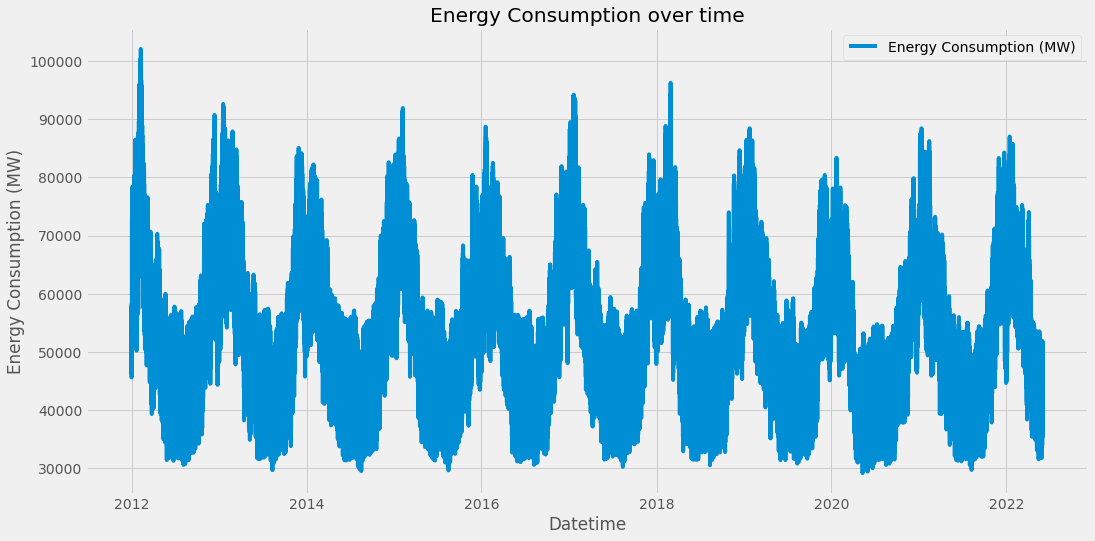

In [28]:
# Plotting the energy consumption over datetime :

plt.figure(figsize=(16,8))
plt.plot(df['Consumption (MW)'], label='Energy Consumption (MW)')
plt.title('Energy Consumption over time')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend(loc='best')
plt.show()

We can see that there is an seasonal pattern.

## We checked the outliers in XGBoost, there is no outlier in my opinion

## Feature Creation

In [29]:
# Creating new features from datetime in order to use them in the model :

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear
    return df

df = create_features(df)

## Vizualize the New Features and the Target Variable

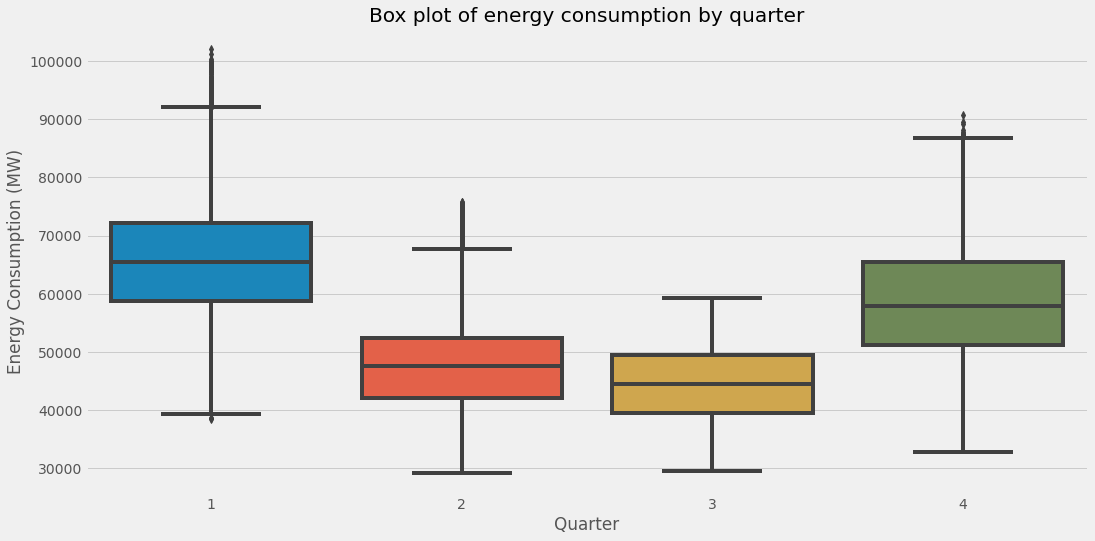

In [30]:
# Box plot of energy consumption by quarter :
plt.figure(figsize=(16,8))
sns.boxplot(x='quarter', y='Consumption (MW)', data=df)
plt.title('Box plot of energy consumption by quarter')
plt.xlabel('Quarter')
plt.ylabel('Energy Consumption (MW)')
plt.show()

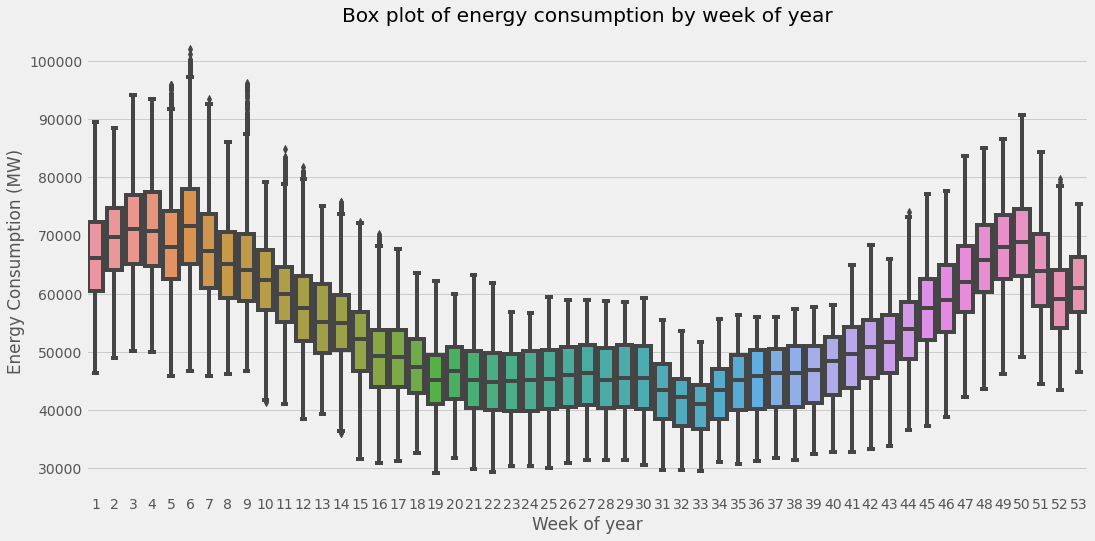

In [31]:
# Box plot of energy consumption by week of year :
plt.figure(figsize=(16,8))
sns.boxplot(x='weekofyear', y='Consumption (MW)', data=df)
plt.title('Box plot of energy consumption by week of year')
plt.xlabel('Week of year')
plt.ylabel('Energy Consumption (MW)')
plt.show()

## Train / Test Split

In [32]:
# Time range of the dataset :
print('The dataset starts from {} and ends at {}'.format(df.index.min(), df.index.max()))

The dataset starts from 2012-01-01 00:00:00 and ends at 2022-05-31 23:30:00


In [33]:
# The dataset starts from 2012-01-01 00:00:00 and ends at 2022-05-31 23:30:00. 
# So we are going to take the data from 2012-01-01 to 2020-01-01 for training set and from 2020-01-01 to 2022-05-31 for test set.
# Train and test split :
train = df.loc[df.index < '2020-01-01']
test = df.loc[df.index >= '2020-01-01']

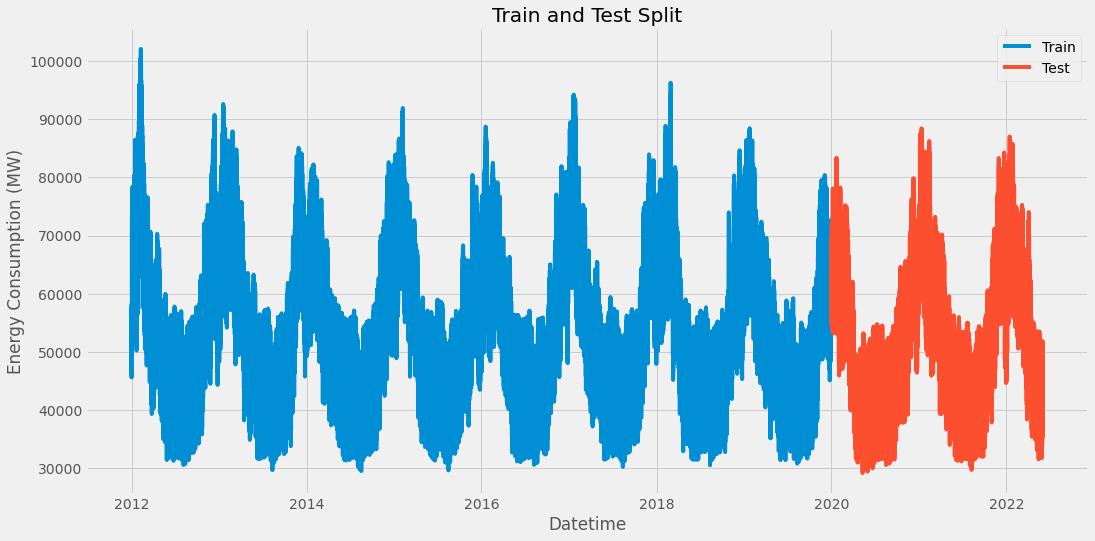

In [34]:
# Plotting the train and test split :
plt.figure(figsize=(16,8))
plt.plot(train['Consumption (MW)'], label='Train')
plt.plot(test['Consumption (MW)'], label='Test')
plt.title('Train and Test Split')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.legend(loc='best')
plt.show()

## Prophet Model

Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    
    Datetime column named: ds
    
    target : y

In [37]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index().rename(columns={'Datetime':'ds','Consumption (MW)':'y'})

In [39]:
train_prophet.head()

,ds,date,Year,Month,Day,Hour,Weekday,y,Fuel oil (MW),Coal (MW),...,Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear
0,2012-01-01 00:00:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,-862,-2625,-2940,1,11.7,4.6,7.1,1,1,52
1,2012-01-01 00:30:00,2012-01-01,2012,1,1,0,6,58315,492,25,...,-862,-2625,-2940,1,11.7,4.6,7.1,1,1,52
2,2012-01-01 01:00:00,2012-01-01,2012,1,1,1,6,56231,492,25,...,-862,-2625,-2714,1,11.7,4.6,7.1,1,1,52
3,2012-01-01 01:30:00,2012-01-01,2012,1,1,1,6,56075,491,25,...,-862,-2625,-2714,1,11.7,4.6,7.1,1,1,52
4,2012-01-01 02:00:00,2012-01-01,2012,1,1,2,6,55532,492,25,...,-862,-2327,-1088,1,11.7,4.6,7.1,1,1,52


In [41]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


CPU times: user 4min 2s, sys: 4.74 s, total: 4min 7s
Wall time: 4min 14s


In [42]:
# Creating a new dataframe for test set with ds and y columns' names :
test_prophet = test.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
test_prophet.head()

,ds,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),...,Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear
0,2020-01-01 00:00:00,2020-01-01,2020,1,1,0,2,67068,300,14,...,-1954,-2267,1763,1,4.0,4.6,-0.6,1,1,1
1,2020-01-01 00:30:00,2020-01-01,2020,1,1,0,2,66103,107,13,...,-1954,-2267,1763,1,4.0,4.6,-0.6,1,1,1
2,2020-01-01 01:00:00,2020-01-01,2020,1,1,1,2,63943,106,13,...,-1867,-2527,1035,1,4.0,4.6,-0.6,1,1,1
3,2020-01-01 01:30:00,2020-01-01,2020,1,1,1,2,63904,107,14,...,-1867,-2527,1085,1,4.0,4.6,-0.6,1,1,1
4,2020-01-01 02:00:00,2020-01-01,2020,1,1,2,2,63408,107,14,...,-1480,-2463,1668,1,4.0,4.6,-0.6,1,1,1


In [44]:
# Predict on test set with model
test_forcast = prophet_model.predict(test_prophet) # We save the predictions in a new dataframe called test_forcast

In [45]:
test_forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,53399.191133,57669.056070,69534.389103,53399.191133,53399.191133,10204.338643,10204.338643,10204.338643,-332.824242,...,2136.782087,2136.782087,2136.782087,8400.380798,8400.380798,8400.380798,0.0,0.0,0.0,63603.529776
1,2020-01-01 00:30:00,53399.169275,57677.058502,69087.859288,53399.169275,53399.169275,9715.372267,9715.372267,9715.372267,-827.903103,...,2137.347732,2137.347732,2137.347732,8405.927638,8405.927638,8405.927638,0.0,0.0,0.0,63114.541542
2,2020-01-01 01:00:00,53399.147417,56429.056355,67764.466615,53399.147417,53399.147417,8902.492897,8902.492897,8902.492897,-1648.137409,...,2139.129639,2139.129639,2139.129639,8411.500668,8411.500668,8411.500668,0.0,0.0,0.0,62301.640313
3,2020-01-01 01:30:00,53399.125559,55241.600522,67105.936391,53399.125559,53399.125559,7737.212728,7737.212728,7737.212728,-2822.000266,...,2142.113142,2142.113142,2142.113142,8417.099853,8417.099853,8417.099853,0.0,0.0,0.0,61136.338287
4,2020-01-01 02:00:00,53399.103701,54166.814552,65577.981816,53399.103701,53399.103701,6283.408103,6283.408103,6283.408103,-4285.595394,...,2146.278336,2146.278336,2146.278336,8422.725160,8422.725160,8422.725160,0.0,0.0,0.0,59682.511803


In [47]:
test_forcast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42336 entries, 0 to 42335
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          42336 non-null  datetime64[ns]
 1   trend                       42336 non-null  float64       
 2   yhat_lower                  42336 non-null  float64       
 3   yhat_upper                  42336 non-null  float64       
 4   trend_lower                 42336 non-null  float64       
 5   trend_upper                 42336 non-null  float64       
 6   additive_terms              42336 non-null  float64       
 7   additive_terms_lower        42336 non-null  float64       
 8   additive_terms_upper        42336 non-null  float64       
 9   daily                       42336 non-null  float64       
 10  daily_lower                 42336 non-null  float64       
 11  daily_upper                 42336 non-null  float64   

In [ ]:
# We have new columns in the dataframe because prophet model is a time series model and it uses the previous values to predict the next values.
# So we have the predicted values in the yhat column and the lower and upper bounds of the predicted values in the yhat_lower and yhat_upper columns.
# We are going to plot the predicted values and the actual values to see how the model performs.

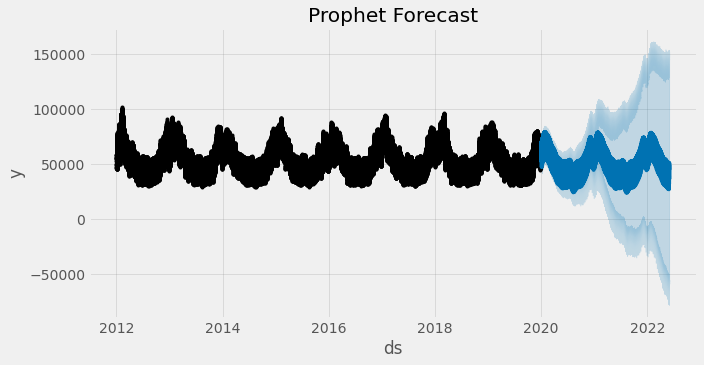

In [50]:
# Plotting the predicted values and the actual values :
fig, ax = plt.subplots(figsize=(10, 5))
fig = prophet_model.plot(test_forcast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

In the plot above, we can see that the model is not able to predict the peaks in the energy consumption. But it is able to predict the general trend of the energy consumption.

Prophet models do not have feature importances like some other models such as random forests or gradient boosting models. However, we can still investigate the impact of individual regressors on the forecast by plotting the trend and seasonality components of the model.

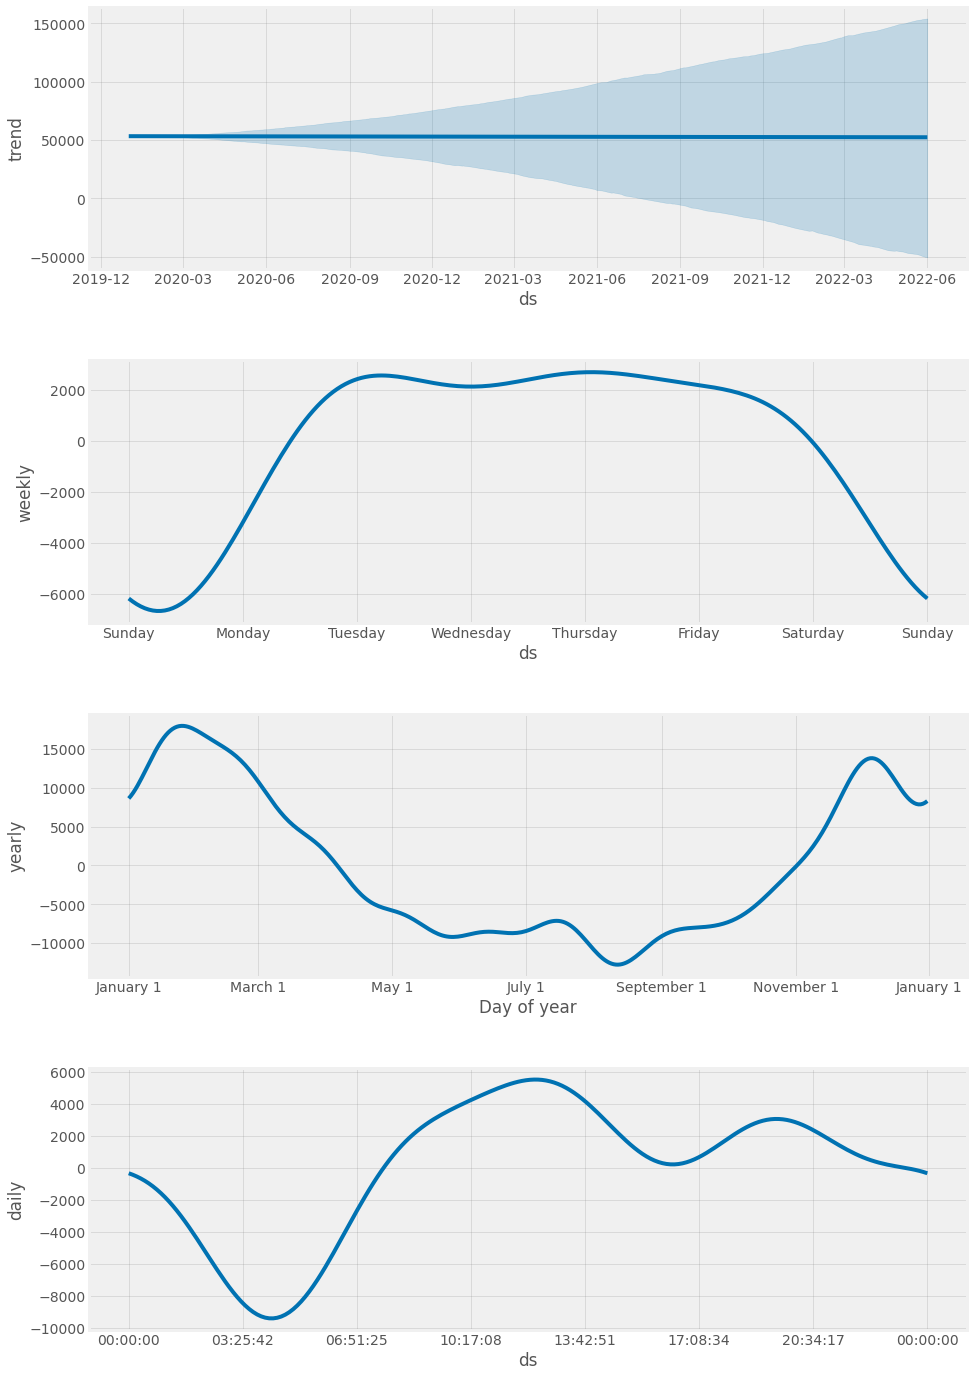

In [60]:
# Plotting the components of the model
fig = prophet_model.plot_components(test_forcast) 
# Size of the plot :
fig.set_size_inches(15, 20)
plt.show()

In the plot above we can see the trend of the energy consumption over time, the yearly seasonality, the weekly seasonality and the daily seasonality. The trend seems to be flat over the years. And we can observe the same patterns in the seasonality of the components as what we've seen in the EDA part. 

## Compare Forecast to Actuals

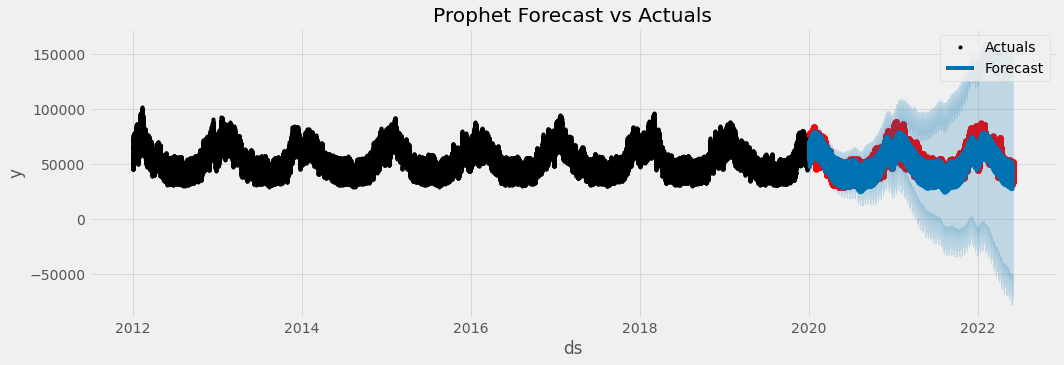

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Consumption (MW)'], color='r')
fig = prophet_model.plot(test_forcast, ax=ax)
ax.set_title('Prophet Forecast vs Actuals')
ax.legend(['Actuals','Forecast'])

The plot shows that the model is working pretty well and it is able to capture the seasonality and the trend of the data.
It has some difficulties in predicting the peaks of the data but it still in the confidence interval.

## Evaluate the model with Error Metrics

In [103]:
# Calculate R-squared (it is not a built-in function in prophet)
y_true = test['Consumption (MW)']
y_pred = test_forcast['yhat']
r2 = r2_score(y_true, y_pred)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_true=test['Consumption (MW)'], y_pred=test_forcast['yhat']))
mae = mean_absolute_error(y_true=test['Consumption (MW)'], y_pred=test_forcast['yhat'])
mape = mean_absolute_percentage_error(y_true=test['Consumption (MW)'],y_pred=test_forcast['yhat'])

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print('R-squared: {:.3f}'.format(r2))

Evaluation Metrics:
Root Mean Squared Error (RMSE): 5064.35 MW
Mean Absolute Error (MAE): 3814.31 MW
Mean Absolute Percentage Error (MAPE): 730.67%
R-squared: 0.812


## Interpretation of the evaluation metrics for Prophet model:

    Root Mean Squared Error (RMSE): 5064.35 MW

This metric measures the average magnitude of the errors in the predictions made by the model. In this case, the RMSE is 5064.35 MW. This means that on average, the model's predictions are off by around 5064.35 MW. The power consumption is around 50 000 MW on average depending on the season.

    Mean Absolute Error (MAE): 3814.31 MW

This metric measures the average absolute difference between the predicted values and the actual values. In this case, the MAE is 3814.31 MW. This means that on average, the model's predictions are off by around 3814.31 MW.  It is similar to the RMSE, but it is not influenced by outliers. The MAE can be useful for comparing different models or for evaluating the performance of a single model over time.

    Mean Absolute Percentage Error (MAPE): 730.67%

This metric measures the average percentage difference between the predicted values and the actual values. In this case, the MAPE is 730.67%. This means that on average, the model's predictions are off by around 730.67% of the actual value. It's important to note that this metric can be sensitive to outliers, and a high MAPE value can indicate that the model is not performing well on some segments of the data.

    R-squared: 0.812

This metric measures the proportion of the variation in the target variable that is explained by the model. In this case, the R-squared value is 0.812, which indicates that the model explains around 81.2% of the variation in the target variable. A higher R-squared value is generally better, as it indicates that the model is able to capture a larger proportion of the variation in the data.

Overall, these metrics suggest that the Prophet model is performing reasonably well, but there is certainly room for improvement. The RMSE and MAE values indicate that the model's predictions are off by a significant amount on average, and the high MAPE value suggests that the model may not be performing well on some segments of the data. However, the high R-squared value indicates that the model is able to capture a significant proportion of the variation in the target variable. To improve the model's performance, you could try adjusting the model parameters, exploring different feature engineering techniques, or trying a different modeling approach altogether.

## Comparing with XGBoost Metrics

XGBoost Metrics :

    Root Mean Squared Error: 3023.45
    Mean Absolute Error: 2259.36
    Mean Absolute Percentage Error: 4.18%

Based on the evaluation metrics, it appears that the XGBoost model outperforms the Prophet model for energy consumption prediction. The XGBoost model has a lower RMSE and MAE, indicating that it is able to predict more accurate values for energy consumption. Additionally, the MAPE for the XGBoost model is significantly lower than that of the Prophet model, indicating that the XGBoost model has a lower average percentage error in its predictions.

Overall, the XGBoost model appears to be more effective for predicting energy consumption than the Prophet model. 

Interpreting the feature importance :
The most important feature is the Reference temperature (°C) with a feature importance of 0.7. It means that the model uses the reference temperature to split the data across all trees. 0.7 is the number of times the reference temperature is used to split the data across all trees.

## Predict the Future

In [88]:
df.tail()

,date,Year,Month,Day,Hour,Weekday,Consumption (MW),Fuel oil (MW),Coal (MW),Gas (MW),...,Trading with Italy (MW),Trading with Switzerland (MW),Trading with Germany-Belgium (MW),Flag Holiday,Average temperature (°C),Reference temperature (°C),Temperature Deviation (°C),quarter,dayofyear,weekofyear
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-05-31 21:30:00,2022-05-31,2022,5,31,21,1,44043,83,454,4025,...,-1319,168,-975,0,16.7,17.4,-0.7,2,151,22
2022-05-31 22:00:00,2022-05-31,2022,5,31,22,1,44019,82,274,3908,...,-96,897,-365,0,16.7,17.4,-0.7,2,151,22
2022-05-31 22:30:00,2022-05-31,2022,5,31,22,1,45067,83,192,3879,...,-96,1100,-65,0,16.7,17.4,-0.7,2,151,22
2022-05-31 23:00:00,2022-05-31,2022,5,31,23,1,46703,81,3,3933,...,-621,1050,1056,0,16.7,17.4,-0.7,2,151,22
2022-05-31 23:30:00,2022-05-31,2022,5,31,23,1,45279,82,2,3748,...,-621,1100,1056,0,16.7,17.4,-0.7,2,151,22


In [93]:
# Building a new data frame to predict the energy consumption in the next 3 years :
future = prophet_model.make_future_dataframe(periods=35040, freq='30min', include_history=False) # 35040 = 3 years * 365 days * 48 periods (30 min)
future.tail()

,ds
35035,2021-12-30 21:30:00
35036,2021-12-30 22:00:00
35037,2021-12-30 22:30:00
35038,2021-12-30 23:00:00
35039,2021-12-30 23:30:00


In [100]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,53399.191133,57932.899780,69366.949780,53399.191133,53399.191133,10204.338643,10204.338643,10204.338643,-332.824242,...,2136.782087,2136.782087,2136.782087,8400.380798,8400.380798,8400.380798,0.0,0.0,0.0,63603.529776
1,2020-01-01 00:30:00,53399.169275,57364.051827,68759.997155,53399.169275,53399.169275,9715.372267,9715.372267,9715.372267,-827.903103,...,2137.347732,2137.347732,2137.347732,8405.927638,8405.927638,8405.927638,0.0,0.0,0.0,63114.541542
2,2020-01-01 01:00:00,53399.147417,56534.688959,67842.741692,53399.147417,53399.147417,8902.492897,8902.492897,8902.492897,-1648.137409,...,2139.129639,2139.129639,2139.129639,8411.500668,8411.500668,8411.500668,0.0,0.0,0.0,62301.640313
3,2020-01-01 01:30:00,53399.125559,55567.856481,66974.938464,53399.125559,53399.125559,7737.212728,7737.212728,7737.212728,-2822.000266,...,2142.113142,2142.113142,2142.113142,8417.099853,8417.099853,8417.099853,0.0,0.0,0.0,61136.338287
4,2020-01-01 02:00:00,53399.103701,54595.061098,65379.397360,53399.103701,53399.103701,6283.408103,6283.408103,6283.408103,-4285.595394,...,2146.278336,2146.278336,2146.278336,8422.725160,8422.725160,8422.725160,0.0,0.0,0.0,59682.511803


I don't the time range starts from 2020 ? It's using the train set ?

In [94]:
forecast = prophet_model.predict(future) # Saving the predictions in a new dataframe called forecast

In [97]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
35035,2021-12-30 21:30:00,52633.396281,-14347.074569,139552.708638,-26126.805642,130663.304914,11762.169095,11762.169095,11762.169095,1244.742929,...,2266.371513,2266.371513,2266.371513,8251.054653,8251.054653,8251.054653,0.0,0.0,0.0,64395.565376
35036,2021-12-30 22:00:00,52633.374423,-13445.842293,140575.660388,-26129.928465,130665.947593,11235.394686,11235.394686,11235.394686,726.983648,...,2252.582375,2252.582375,2252.582375,8255.828663,8255.828663,8255.828663,0.0,0.0,0.0,63868.769109
35037,2021-12-30 22:30:00,52633.352565,-16048.604707,141254.406428,-26133.051288,130668.590271,10858.853661,10858.853661,10858.853661,359.464212,...,2238.759724,2238.759724,2238.759724,8260.629725,8260.629725,8260.629725,0.0,0.0,0.0,63492.206225
35038,2021-12-30 23:00:00,52633.330707,-16678.388515,138435.609384,-26136.174111,130671.232949,10615.881712,10615.881712,10615.881712,125.551373,...,2224.872528,2224.872528,2224.872528,8265.457811,8265.457811,8265.457811,0.0,0.0,0.0,63249.212419
35039,2021-12-30 23:30:00,52633.308849,-14305.121030,138119.894210,-26139.296934,130673.875628,10419.992724,10419.992724,10419.992724,-61.205513,...,2210.885341,2210.885341,2210.885341,8270.312896,8270.312896,8270.312896,0.0,0.0,0.0,63053.301573


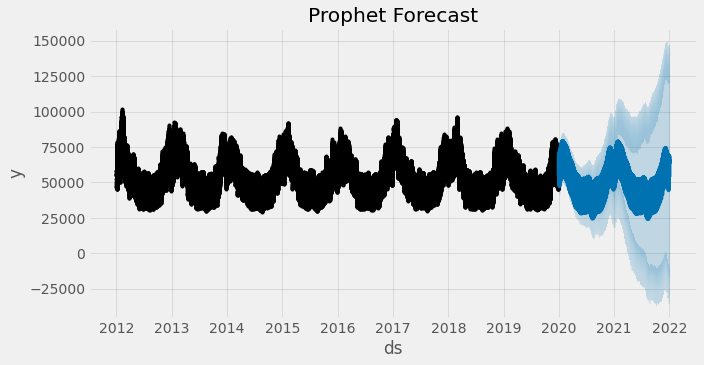

In [95]:
# Plotting the predicted values :
fig, ax = plt.subplots(figsize=(10, 5))
fig = prophet_model.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Saving the model

In [99]:
# Saving the model :
import pickle
#pickle.dump(prophet_model, open('model_Prophet.pkl', 'wb'))

# Loading the model :
#model_Prophet = pickle.load(open('model_Prophet.pkl', 'rb'))

# Checking the model :
#prophet_model.predict(future)

# END OF PROPHET MODEL
## GO TO PROPHET NOTEBOOK TO CHECK THE OTHER MODEL & THE COMPARAISON BETWEEN THE MODELS